In [1]:
import sys
# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
from data_providers import ClickHouseConnector
from data_providers import DbDataProviderRT5

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from train_tools import plot_and_go
from basic_application import with_debug_time

%matplotlib notebook
db_connect_params = {
    "host" : "217.197.116.177",
    "port" : 59000,
    "user" : "alex",
    "password" : "Xrxcmr758",
    "database" : "rt5"
}

In [3]:
import time
import numpy as np
import pandas as pd

## DatasetDownload

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


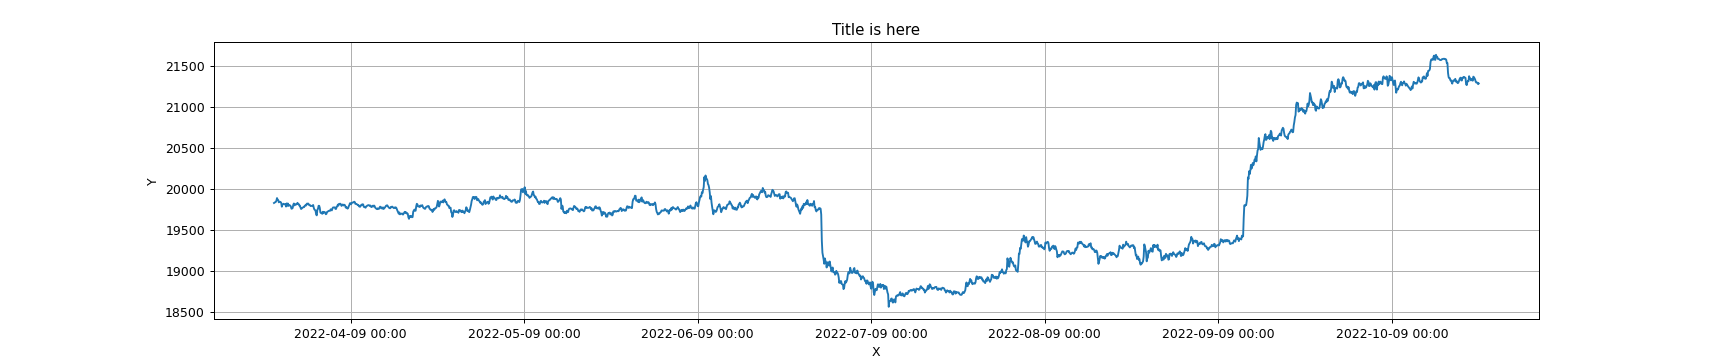

(2000, 11)


In [92]:
pair = "BTC_USDT"
ts = "2022-09-10 12:00:00"
period = 300
num_of_periods = 2000


with ClickHouseConnector(db_connect_params) as connector:
    
    data_provider = DbDataProviderRT5(connector)
    data = data_provider.get(ts, period, num_of_periods, pair, raise_errors=False, fill_gaps=True)
        
plot_and_go(data, fig_x=19, fig_y=4, dpi=50)

# Rates Feature

In [97]:

import logging
import numpy as np
import pandas as pd
import json


logger = logging.getLogger(__name__)


class PrecomputeOrderbookDiffFeature:
    def __init__(self):
        self.level = 0.0025
        
    def precompute(self, data, level):
    
        self.level = level
        # 1. Построить объемы по asks и bids
        asks_vols, bids_vols = self._convert_orderbook(data)
    

        # 5. Значение точки данных
        asks_feature = np.concatenate([np.zeros(1), asks_vols])
        bids_feature = np.concatenate([np.zeros(1), bids_vols])
        
        data["asks_" + str(level)] = asks_feature
        data["bids_" + str(level)] = bids_feature
        
        return data

    def _get_volume(self, asks, bids, lowest_ask, highest_bid):
        keys_asks = np.array(list(map(float, asks.keys())))
        vols_asks = np.array(list(map(float, asks.values())))

        keys_bids = np.array(list(map(float, bids.keys())))
        vols_bids = np.array(list(map(float, bids.values())))

        mask_ask = keys_asks < lowest_ask * (1 + self.level)
        ask_vol = sum(vols_asks[mask_ask])

        mask_bid = keys_bids > highest_bid * (1 - self.level)
        bid_vol = sum(vols_bids[mask_bid])

        return ask_vol, bid_vol

    def _convert_orderbook(self, data):
        asks_vol_arr, bids_vol_arr = [], []
        idxs = data.index.values

        index_length = len(idxs)
        for i in range(index_length - 1):
            idx_curr = idxs[i + 1]
            asks_curr = data.loc[idx_curr, "asks"] #json.loads(data.loc[idx_curr, "asks"].replace("\'", "\""))
            bids_curr = data.loc[idx_curr, "bids"] #json.loads(data.loc[idx_curr, "bids"].replace("\'", "\""))

            idx_prev = idxs[i]
            asks_prev = data.loc[idx_prev, "asks"] #json.loads(data.loc[idx_prev, "asks"].replace("\'", "\""))
            bids_prev = data.loc[idx_prev, "bids"] #json.loads(data.loc[idx_prev, "bids"].replace("\'", "\""))

            if len(asks_curr) and len(asks_prev) and len(bids_curr) and len(bids_prev):
                lowest_ask = np.min(np.array(list(map(float, asks_prev.keys()))))
                highest_bid = np.max(np.array(list(map(float, bids_prev.keys()))))

                ask_curr_vol, bid_curr_vol = self._get_volume(asks_curr, bids_curr, lowest_ask, highest_bid)
                asks_vol_arr.append(ask_curr_vol)
                bids_vol_arr.append(bid_curr_vol)
            else:

                asks_vol_arr.append(0)
                bids_vol_arr.append(0)

        return np.array(asks_vol_arr), np.array(bids_vol_arr)


In [99]:
ob = PrecomputeOrderbookDiffFeature()
data2 = ob.precompute(data.iloc[:].copy(), 0.0025)
data2 = ob.precompute(data2, 0.005)
data2 = ob.precompute(data2, 0.0075)
data2 = ob.precompute(data2, 0.001)


In [96]:
data2.head()

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num,asks_0.0025,bids_0.0025
ts,,,,,,,,,,,,,
1662211500,2022-09-03 13:25:00,19830.480469,19830.468750,"{'19830.48': 0.501068, '19832.47': 0.25, '1983...","{'19830.47': 0.251304, '19830.39': 0.5, '19826...",0.428217,0.111290,0.539507,4,13,17,0.000000,0.000000
1662211800,2022-09-03 13:30:00,19834.929688,19834.919922,"{'19834.93': 0.499664, '19836.92': 0.25, '1983...","{'19834.92': 0.5, '19832.46': 0.25, '19830.39'...",0.082748,0.001058,0.083806,3,1,4,6.348009,8.433436
1662212100,2022-09-03 13:35:00,19841.000000,19840.990234,"{'19841': 0.5, '19843.97': 0.25, '19845.98': 0...","{'19840.99': 0.5, '19839': 0.25, '19834.66': 0...",0.558905,0.635804,1.194709,9,7,16,5.852422,7.685621
1662212400,2022-09-03 13:40:00,19843.189453,19843.179688,"{'19843.19': 0.216461, '19844.03': 0.5, '19846...","{'19843.18': 0.501059, '19840.99': 0.25, '1983...",0.091014,0.026258,0.117272,2,2,4,5.819684,7.741844
1662212700,2022-09-03 13:45:00,19859.419922,19859.408203,"{'19859.42': 0.206552, '19860.33': 0.5, '19862...","{'19859.41': 0.25, '19858.29': 0.249378, '1985...",2.078773,0.129076,2.207849,6,6,12,6.607300,4.565010


<IPython.core.display.Javascript object>


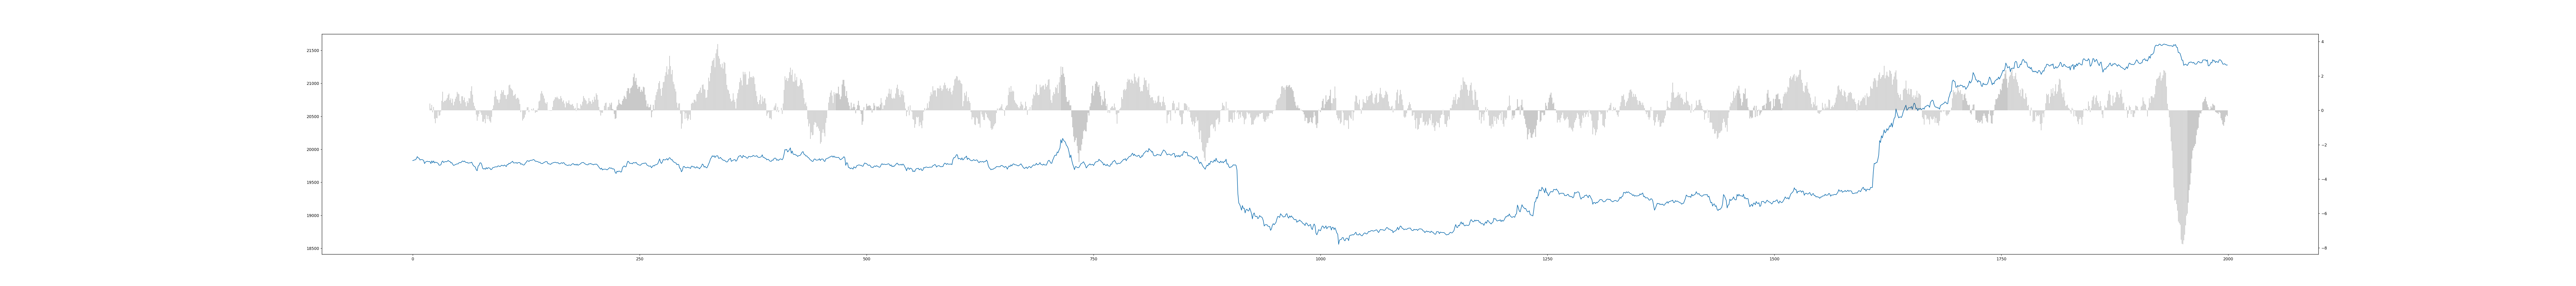

<BarContainer object of 2000 artists>

In [111]:
data2["feature"] = -data2["asks_0.001"] + data2["bids_0.001"]

fig, ax = plt.subplots(figsize=(90,10), dpi=70)
ax2 = ax.twinx()

x_data = list(range(len(data2.index)))

ax.plot(x_data, data2.loc[:, "highest_bid"])

#ax2.plot(x_data, data.loc[:, "bids_0.005"], color=(0.8, 0.3, 0.3), alpha=0.3)
#ax2.plot(x_data, data.loc[:, "asks_0.005"], color=(0.3, 0.8, 0.3), alpha=0.3)

ax2.bar(x=x_data, height=data2.loc[:, "feature"].rolling(20).mean(), color=(0.3, 0.3, 0.3), alpha=0.3)



In [109]:
c1 = np.corrcoef(data2["feature"].rolling(2).mean().fillna(0), data2['highest_bid'].diff().fillna(0))
print("Дата as is: {0:.2f}".format(c1[0,1]))

Дата as is: 0.55


In [65]:
d = [1,2,3,4,5,6,7]
df = pd.DataFrame(d, columns=["feat"])
df.head(10)

,feat
0,1
1,2
2,3
3,4
4,5
5,6
6,7


In [112]:
df["feat"].rolling(1).mean()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
5    6.0
6    7.0
Name: feat, dtype: float64

In [7]:
from core.observation_builder.features.abstract_feature import AbstractFeature
import logging
import numpy as np


In [256]:
class RatesFactorFeature(AbstractFeature):
    SCALE_FACTOR = 10

    def __init__(self, context, step_factor=[1]):
        super().__init__(context)
        self.step_factor = step_factor

    def get(self):
        data_point = self.context.data_point
        current_price = data_point.get_value("highest_bid")
        ts = data_point.get_current_index()
        axis_0_shape = data_point.obs_len
        obs = []
        for sf in self.step_factor:
            period = dp.period*sf
            rates = data_point.get_values(name="highest_bid", num=dp.obs_len*sf, as_ndarray=False)
            rates = pd.DataFrame(rates)
            rates["highest_bid"] = (rates["highest_bid"] / current_price - 1)*self.SCALE_FACTOR
            rates["group"] = rates.index - ts
            rates["group"] = np.ceil(rates["group"]/period)*period
            rates = rates.groupby(["group"]).mean()
            new_idx = np.array(list(map(int, rates.index + int(ts))))
            rates = rates.set_index(new_idx)
            obs.append(rates.values.reshape(-1, 1))
        #logger.debug("Get rates -> current price {0} | {1}".format(current_price, rates))
        feature = np.concatenate([*obs], axis=1)
        return feature

In [257]:
from core import RTCore
from core.context import BasicContext
from core.tickers import TickerExtendedReward
from core.observation_builder import ObservationBuilderBasic

from data_point import DataPointFactory

In [258]:
context = BasicContext()

In [259]:
params = {
    "period": 300,              # Интервал между точками наблюдения в сэмпле. При значении 300 берутся 5-ти минутные срезы.
    "n_observation_points": 5, # Количество точек наблюдения в сэмпле
    "n_history_points": 80,
    "n_future_points": 0,       # Количество будущех точек для предсказания тренда (временное решение)
    "step_size": 300              # Шаг по датасету
 }

dpf = DataPointFactory(dataset=data, **params)

In [260]:
dp = dpf.get_current_step()

In [261]:
context.update_datapoint(dp)

In [262]:
rft = RatesFactorFeature(context, step_factor=[1, 3, 6, 12])
obs = rft.get()

#fig, ax = plt.subplots(figsize=(10,4))
#ax.plot(obs)

In [263]:
dp.get_current_index()

1662236700

In [264]:
obs

array([[-0.01031399, -0.00740151,  0.04740973,  0.03879458],
       [ 0.00247002,  0.03268163,  0.0376914 ,  0.03839463],
       [-0.00660658,  0.0050652 ,  0.00201931,  0.04317194],
       [ 0.0020647 , -0.00401596,  0.01887341,  0.01985535],
       [ 0.        , -0.00151396, -0.00276496,  0.00805423]],
      dtype=float32)

In [214]:
obs

,highest_bid
group,
1.662224e+09,19807.412109
1.662227e+09,19782.775391
1.662231e+09,19806.302734
1.662235e+09,19745.261719
1.662238e+09,19711.220703
1.662242e+09,19745.843750
1.662245e+09,19784.839844
1.662249e+09,19786.625000
1.662253e+09,19829.404297


In [215]:
obs[1]

KeyError: 1

In [114]:
np.concatenate([*obs], axis=1)

array([[ 0.01763344, -0.07069945, -0.08335412, -0.02372622],
       [ 0.02165675, -0.07177591, -0.08003175, -0.03330171],
       [ 0.01087785, -0.06018281, -0.09727955, -0.02946019],
       [ 0.00401616, -0.07338762, -0.05755067, -0.07591426],
       [ 0.02215862, -0.07234514, -0.03834546, -0.07027566],
       [ 0.01381278, -0.06826699, -0.03535569, -0.05089998],
       [ 0.01381755, -0.04895151, -0.0524497 , -0.0349772 ],
       [ 0.00930667, -0.06982803, -0.03781736, -0.03053188],
       [ 0.00200272, -0.04265487, -0.07225573, -0.02434552],
       [ 0.00127792,  0.00534058, -0.0466311 , -0.04106879],
       [ 0.01426697,  0.01947522, -0.02732575, -0.04044354],
       [ 0.01426697,  0.01904368, -0.01357734, -0.05167127],
       [ 0.01076221,  0.00106096, -0.02649486, -0.04000604],
       [ 0.01426697, -0.00739098, -0.04737139, -0.04433632],
       [ 0.01443624, -0.01796722, -0.06155252, -0.08883178],
       [ 0.02252698, -0.02425492, -0.07177591, -0.08003175],
       [ 0.0176549 ,  0.

<IPython.core.display.Javascript object>


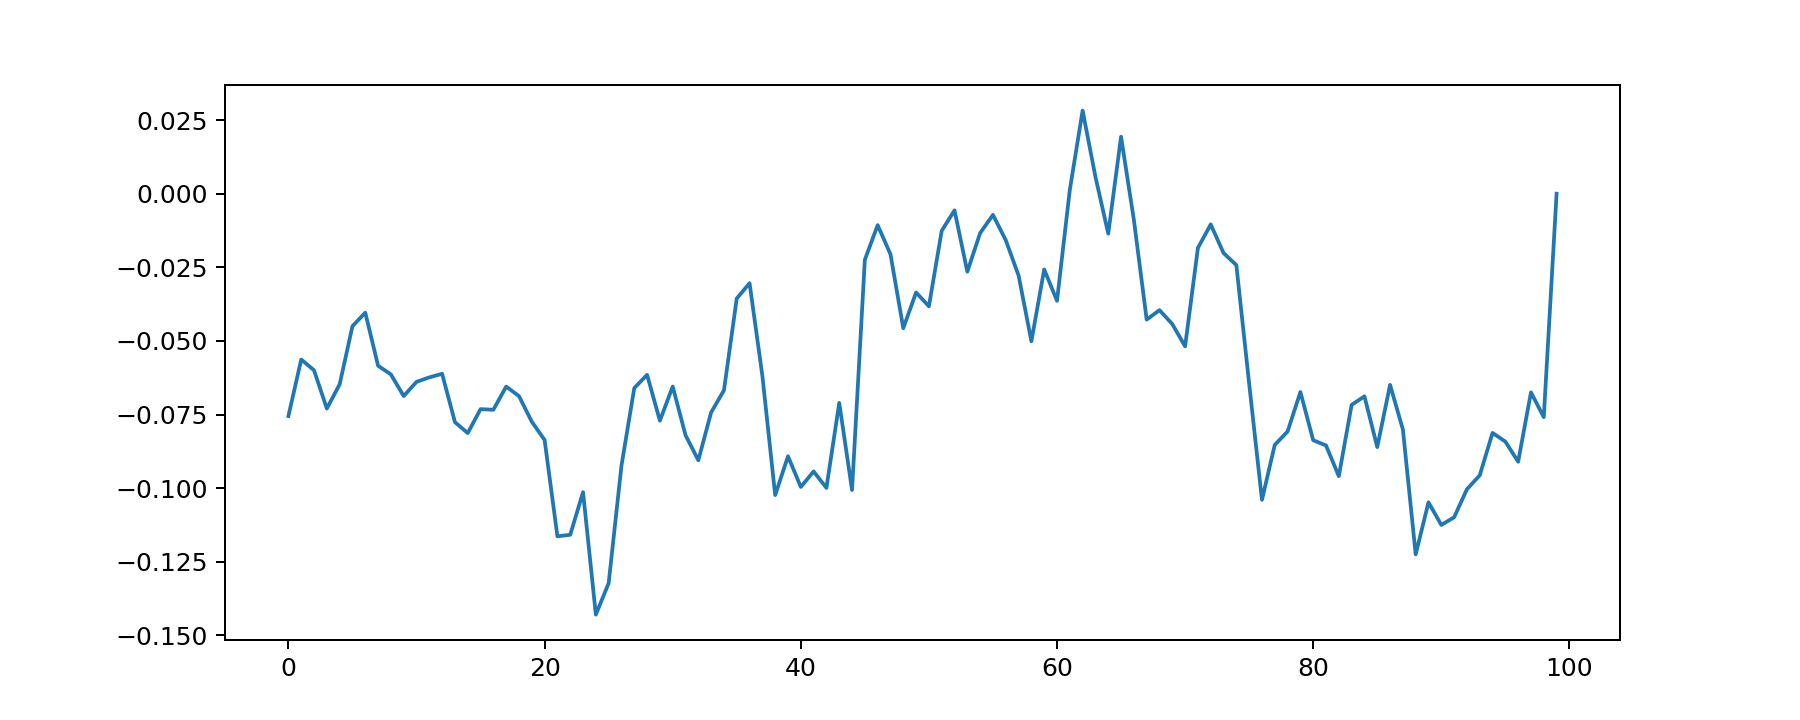

In [54]:
rft = RatesFactorFeature(context, step_factor=5)
obs = rft.get()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(obs)

# DataPointV2

In [206]:
import numpy as np
from basic_application import with_exception

class DataPointError(Exception):
    pass


class DataPoint:
    def __init__(self, data, n_observation_points=10, n_future_points=0, period=1):
        self.data = data

        self.fut_len = n_future_points
        self.obs_len = n_observation_points
        self.hist_len = len(self.data) - n_future_points - n_observation_points

        # Верхушка observation = текущая точка данных
        self.current_idx = self.data.index[-(self.fut_len + 1)]

        # Начало observation
        self.start_idx = self.data.index[self.hist_len]

        self.period = period # self.data.index[1] - self.data.index[0]

        
    def get_values(self, cursor=None, num=None, name=None, step_factor=1, as_ndarray=True):
        if name is None:
            name = self.data.columns
        idxs = self.get_indexes(cursor=cursor, num=num, step_factor=step_factor)

        if as_ndarray:
            result = self.data.loc[idxs, name].values
        else:
            result = self.data.loc[idxs, name]

        return result
    
    def get_value(self, name, cursor=None):
        value = self.get_values(name=name, num=1, cursor=cursor)
        return value[0]
    
    def get_current_index(self):
        return self.current_idx
        
    def get_indexes(self, cursor=None, num=None, step_factor=1):
        if cursor is None:
            cursor = self.current_idx

        if num is None:
            num = self.obs_len

        period = self.period * step_factor

        if num > 0:
            stop = cursor - (period * (num - 1))
            idxs = np.arange(stop, cursor + period, period)
        else:
            stop = cursor - (period * (num - 1))
            idxs = np.arange(cursor + period, stop, period)

        return idxs

In [207]:
data.head()

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num
ts,,,,,,,,,,,
1662796500,2022-09-10 07:55:00,21352.500000,21352.310547,"{'21352.5': 0.394, '21379.27': 0.036275, '2138...","{'21352.31': 0.000629, '21352.3': 0.002616, '2...",1.555272,0.011891,1.567163,54,11,65
1662796800,2022-09-10 08:00:00,21353.130859,21274.349609,"{'21353.13': 0.480706, '21354.98': 0.280799, '...","{'21274.35': 0.095289, '21252.3': 0.003414, '2...",0.109545,0.013863,0.123408,42,8,50
1662797100,2022-09-10 08:05:00,21326.000000,21284.560547,"{'21326': 0.690315, '21339.2': 0.020079, '2134...","{'21284.56': 0.097647, '21252.3': 0.003414, '2...",0.346015,0.389333,0.735348,158,35,193
1662797400,2022-09-10 08:10:00,21325.759766,21293.109375,"{'21325.76': 0.689794, '21345.84': 0.235, '213...","{'21293.11': 0.001296, '21291.5': 0.7, '21254....",2.672747,0.677586,3.350333,107,106,213
1662797700,2022-09-10 08:15:00,21304.380859,21281.400391,"{'21304.38': 0.07549, '21325.76': 0.7, '21338....","{'21281.4': 0.7, '21276.31': 0.097267, '21252....",1.764921,0.645449,2.410370,73,115,188


In [208]:
dp = DataPoint(data, n_observation_points=10, n_future_points=5, period=300)

In [209]:
dp.get_indexes()

array([1662807000, 1662807300, 1662807600, 1662807900, 1662808200,
       1662808500, 1662808800, 1662809100, 1662809400, 1662809700])

In [210]:
ss = dp.get_values(name="highest_bid", num=2, as_ndarray=True)
ss

array([21327.541, 21294.281], dtype=float32)

In [211]:
dd = dp.get_value("highest_bid", cursor = 1662797100)
dd

21284.56

In [212]:
dp.get_current_index()

1662809700

In [157]:
ss.diff().dropna().values

array([-20.488281, -33.259766], dtype=float32)

In [148]:
cursor = dp.get_indexes(num=1)
dp.get_values(cursor=cursor, num=dp.hist_len, as_ndarray=False)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num
ts,,,,,,,,,,,
1662799500,2022-09-10 08:45:00,21344.490234,21317.599609,"{'21344.49': 0.096623, '21344.78': 0.212242, '...","{'21317.6': 0.7, '21306.54': 0.234, '21297.13'...",1.143023,0.328697,1.471720,24,16,40
1662799800,2022-09-10 08:50:00,21310.361328,21309.750000,"{'21310.36': 0.204283, '21318': 0.235, '21319....","{'21309.75': 0.670705, '21307.18': 0.013668, '...",0.249728,1.624330,1.874058,9,31,40
1662800100,2022-09-10 08:55:00,21321.199219,21319.800781,"{'21321.2': 0.195339, '21326': 0.232063, '2134...","{'21319.8': 0.211053, '21300.99': 0.386166, '2...",0.834215,0.747824,1.582039,19,31,50
1662800400,2022-09-10 09:00:00,21305.599609,21296.740234,"{'21305.6': 0.196293, '21308.23': 0.210702, '2...","{'21296.74': 0.665715, '21276.67': 0.011152, '...",0.203970,1.093149,1.297119,24,27,51
1662800700,2022-09-10 09:05:00,21292.119141,21291.371094,"{'21292.12': 0.03, '21293.5': 0.235, '21295.63...","{'21291.37': 0.434304, '21283.46': 0.012226, '...",0.047145,0.374906,0.422051,8,38,46
1662801000,2022-09-10 09:10:00,21296.298828,21292.869141,"{'21296.3': 0.123634, '21307.61': 0.004343, '2...","{'21292.87': 0.234758, '21290.43': 0.235, '212...",1.571577,1.358688,2.930265,27,66,93
1662801300,2022-09-10 09:15:00,21313.320312,21312.349609,"{'21313.32': 0.235, '21315.46': 0.235, '21316....","{'21312.35': 0.7, '21311.26': 0.235, '21309': ...",0.777562,1.200628,1.978190,10,59,69
1662801600,2022-09-10 09:20:00,21337.880859,21332.740234,"{'21337.88': 0.03043, '21343.85': 0.235, '2134...","{'21332.74': 0.235, '21328.78': 0.500289, '213...",1.094926,0.835427,1.930353,15,13,28
1662801900,2022-09-10 09:25:00,21353.378906,21327.929688,"{'21353.38': 0.226739, '21355.52': 0.235, '213...","{'21327.93': 0.136858, '21327.12': 0.468816, '...",2.060175,0.863481,2.923656,22,14,36


In [141]:
import json

In [146]:
cursor_prev = dp.get_indexes(num=1)
data_raw = dp.get_values(name="asks", num=1, cursor=cursor_prev, as_ndarray=False)
data_raw

{'21307.77': 0.01,
 '21316.5': 0.189,
 '21321.21': 0.002199,
 '21325.77': 0.7,
 '21327.7': 0.002551,
 '21330.13': 0.00247,
 '21331.14': 0.001882,
 '21333.7': 0.8,
 '21340.02': 0.14,
 '21346': 0.394,
 '21363.4': 0.00354,
 '21365': 0.000411,
 '21400': 0.04,
 '21406': 0.03,
 '21409.16': 0.002787,
 '21414.06': 0.003403,
 '21418.9': 0.001191,
 '21418.94': 0.00116,
 '21421.21': 0.004,
 '21450': 0.008464,
 '21450.93': 3.956,
 '21464.38': 0.003394,
 '21500': 0.001,
 '21514.81': 0.003387,
 '21565.37': 0.003378,
 '21574.82': 0.031452,
 '21576.76': 0.2,
 '21578.64': 0.030488,
 '21587.36': 0.028802,
 '21593.51': 0.061227,
 '21593.55': 0.09926,
 '21594.98': 0.09926,
 '21600': 0.188825,
 '21602.57': 1.964,
 '21604.16': 6.7e-05,
 '21605.92': 0.000852,
 '21616.04': 0.003373,
 '21618.9': 0.012761,
 '21624.38': 0.031118,
 '21624.39': 0.005516,
 '21626.11': 0.031118,
 '21640': 5e-05,
 '21650': 0.089387,
 '21654': 0.52487,
 '21666.84': 0.003361,
 '21672.01': 0.001153,
 '21673.71': 0.009192,
 '21685.05': 0

In [97]:
orderbook_prev = json.loads(data_raw.replace("\'", "\""))

1

In [102]:
np.arange(20,10,-1)

array([20, 19, 18, 17, 16, 15, 14, 13, 12, 11])

In [81]:
current_idx = 1662811200
n=-1


if n > 0:
    period = data.index[0] - data.index[1]
    stop = current_idx + (period * n)
else:
    period = data.index[1] - data.index[0]
    stop = current_idx - (period * n)

idxs = np.arange(current_idx, stop, period)
idxs

array([1662811200])

In [82]:
def get_values(name=None, cursor=None, step_factor=1, num=None):

    if cursor is None:
        cursor = current_idx

    if name is None:
        name = data.columns
    
    if num is None:
        num = 4 # observation 
        
    period = (data.index[1] - data.index[0]) * step_factor

    if num > 0:
        stop = cursor - (period * (num-1))
        idxs = np.arange(stop, cursor+period, period)
    else:
        stop = cursor - (period * num)
        idxs = np.arange(cursor, stop, period)
        
    df = data.loc[idxs, name]
    display(df)
    

In [100]:
def get_indexes(cursor=None, step_factor=1, num=None):
         
    if cursor is None:
        cursor = current_idx

    if num is None:
        num = 4

    period = (data.index[1] - data.index[0]) * step_factor

    if num > 0:
        stop = cursor - (period * (num-1))
        idxs = np.arange(stop, cursor+period, period)
    else:
        stop = cursor - (period * num)
        idxs = np.arange(cursor, stop, period)

    return idxs

get_indexes()

array([1662810300, 1662810600, 1662810900, 1662811200])

## Datapoint Factory

In [9]:
from data_point import DataPointFactory

In [15]:
n_observation_points = 5
n_future_points = 0
n_history_points = 2
period = 300

dpf = DataPointFactory(
    dataset=data, 
    period=period, 
    n_observation_points=n_observation_points,
    n_history_points = n_history_points,
    n_future_points=n_future_points
)


In [16]:
dp = dpf.get_current_step()

In [17]:
dp.__dict__

{'data':                             dt    lowest_ask   highest_bid  \
 ts                                                           
 1662796500 2022-09-10 07:55:00  21352.500000  21352.310547   
 1662796800 2022-09-10 08:00:00  21353.130859  21274.349609   
 1662797100 2022-09-10 08:05:00  21326.000000  21284.560547   
 1662797400 2022-09-10 08:10:00  21325.759766  21293.109375   
 1662797700 2022-09-10 08:15:00  21304.380859  21281.400391   
 1662798000 2022-09-10 08:20:00  21286.029297  21271.300781   
 1662798300 2022-09-10 08:25:00  21314.351562  21296.478516   
 
                                                          asks  \
 ts                                                              
 1662796500  {'21352.5': 0.394, '21379.27': 0.036275, '2138...   
 1662796800  {'21353.13': 0.480706, '21354.98': 0.280799, '...   
 1662797100  {'21326': 0.690315, '21339.2': 0.020079, '2134...   
 1662797400  {'21325.76': 0.689794, '21345.84': 0.235, '213...   
 1662797700  {'21304.38': 0

In [61]:
dp, done = dpf.get_next_step()
print(done)

True


In [62]:
dp.data

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num
ts,,,,,,,,,,,
1662809400,2022-09-10 11:30:00,21335.001953,21327.541016,"{'21335': 0.1, '21335.01': 0.00098, '21335.79'...","{'21327.54': 0.14, '21327.53': 0.55, '21322.34...",1.316541,1.773979,3.090520,21,30,51
1662809700,2022-09-10 11:35:00,21307.771484,21294.281250,"{'21307.77': 0.01, '21316.5': 0.189, '21321.21...","{'21294.28': 0.14, '21294.27': 0.469515, '2129...",1.292653,1.073682,2.366335,18,17,35
1662810000,2022-09-10 11:40:00,21298.380859,21290.628906,"{'21298.38': 0.01, '21298.73': 0.00247, '21299...","{'21290.63': 0.69, '21290.6': 1.413195, '21280...",1.122753,1.586319,2.709072,15,17,32
1662810300,2022-09-10 11:45:00,21300.250000,21298.650391,"{'21300.25': 0.00073, '21300.26': 0.15, '21307...","{'21298.65': 0.14, '21297.14': 0.69, '21292.09...",1.888513,1.531294,3.419807,19,19,38
1662810600,2022-09-10 11:50:00,21295.941406,21287.980469,"{'21295.94': 0.01, '21299.02': 0.15, '21308.22...","{'21287.98': 0.14, '21287.97': 0.55, '21287.96...",2.045997,1.473329,3.519326,26,15,41
1662810900,2022-09-10 11:55:00,21279.521484,21277.070312,"{'21279.52': 0.001214, '21282.04': 0.15, '2128...","{'21277.07': 0.55, '21273.72': 1.426844, '2126...",0.661370,1.257566,1.918936,10,12,22
1662811200,2022-09-10 12:00:00,21288.179688,21279.009766,"{'21288.18': 1.370121, '21288.19': 0.7, '21289...","{'21279.01': 0.000223, '21273.43': 0.14, '2127...",1.432162,1.484592,2.916754,19,21,40


In [1]:
import sys
# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
from core.observation_builder.features import AbstractFeature, AbstractFeatureWithHistory

In [4]:
a = AbstractFeature(None)

TypeError: Can't instantiate abstract class AbstractFeature with abstract method _get

In [11]:
a.scale_is_broken=True

In [12]:
a.reset()

AbstractFeatureWithHistory: Scale is broken
